# Comparing fmriprep with fslfeat


**<font color='red'>What still needs to be done:</font>**


- <font color='red'>I noticed I'm not very consistent with the use of z- or t-statistics.  I think cohen's D is computed on T and should ideally be computed on Z.  That will be the most important difference, but the whole deal should be checked for consistency.</font> 

- <font color='red'>plug in full results of smoothness estimates of group analyses (now based on 5 exp, running now --> rerunning the notebook in about an hour should make this ok).</font> 

- <font color='red'>Address notes in the text and add references (to afni, FSL, HCP paper wrt ACM, papers related to data).</font> 
- <font color='red'>Probably when everything is done, it would be good to re-run everything.  It's not that computationally intensive (with some sherlock-power, it could be done in 24h).  Maybe then also extend beyond 100 subjects.  We have 272 subjects, so we can go up to 136 per subsample.</font> 
- <font color='red'>Clean out repo.  I already removed most code that isn't used anymore, but the readme could use an update for example.</font> 
- <font color='red'>Right now the 1st, 2nd and ACM analysis was run through the singularity container.  The other parts (collect_results and smoothness) technically could be, but aren't run through the container.  For the notebooks, I'm not even sure you can run that through this singularity container (with display forwarding)...</font> 

To see the impact of the preprocessing pipeline on their most common usecase - activation tasks - we will compare the results of an activation study, where the data was preprocessed with either fmriprep or fsl feat.

## **The data:**
We are using the UCLA Consortium for Neuropsychiatric Phenomics LA5c Study, a dataset that is publicly available on openfmri.org.  During the experiment, subjects performed several tasks, a block of rest, and two anatomical scans.  The study includes imaging data of a large group of healthy individuals from the community, as well as samples of individuals diagnosed with schizoprenia, bipolar disorder, and ADHD.  For this experiment, we will only use the anatomical scans (for coregistration) and the functional scans from the stopsignal task described below.  

**Copied from F1000 paper, so has to be rephrased:** Neuroimaging data were acquired on a 3T Siemens Trio scanner. Functional MRI data were collected with a T2\*-weighted echoplanar imaging (EPI) sequence with parameters: slice thickness = 4mm, 34 slices, TR=2s, TE=30ms, flip angle=90°, matrix=64 × 64, FOV=192mm. A T1-weighted high-resolution anatomical scan (MPRAGE) were collected with the following parameter: slice thickness = 1mm, 176 slices, TR=1.9s, TE=2.26ms, matrix=256 x 256, FOV=250mm. Diffusion weighted imaging data were collected with parameters: slice thickness = 2mm, 64 directions, TR/TE=9000/93ms, flip angle=90°, matrix=96 × 96, axial slices, b=1000s/mm2.

## **The task:**
During this stopsignal task, participants were instructed to respond quickly to a 'go' stimulus. During some of the trials, at unpredictable times, a stop signal would appear after the stimulus is presented.  During those trials, the subject has to inhibit any planned response.  In this experiment, we specifically look into the difference between the brain activation during a successful stop trial and a go trial (contrast: Go - StopSuccess).  We expect to see brain regions responsible for response inhibition (negative) and motor response (positive).

More details about the data and the task can be found:
- in the original data paper: https://www.nature.com/articles/sdata2016110
- on openfMRI, where the data is available: https://openfmri.org/dataset/ds000030/
- in the data paper describing some of the analyses performed here: https://f1000research.com/articles/6-1262/v2
- the code for analyses performed in the last paper is available on github, at an earlier commit (and release) in this repository: https://github.com/poldracklab/CNP_task_analysis

## **The experimental setup**

We processed the data as follows:
1. First the data are preprocessed using either one of the preprocessing pipelines tested.  
2. The data are analysed on the first level: the results are obtained for each subject.
3. We perform group level analyses in a specific resampling scheme to allow a statistical comparison between the pipelines: two random (non-overlapping) subsets of n subjects are repeatedly entered into a second level analysis.  

The first step is the experimental manipulation resulting in two conditions: (1) the data are preprcessed with fmriprep and (2) the data are preprocessed using fslfeat.  The next two steps are identical for both conditions.
We will describe the details on the three different steps in more detail below.

### The preprocessing pipelines:
**Oscar**

### The first level analysis:


<font color='#2471A3'>see CNP_analysis.py</font> 

*Note: I wonder if we should add this to the preprocessing step, since this is the only thing that is still different between the two conditions.*
The output of FSL feat is in native space (not standardised to a brain template) and a warpfile **(?)** is provided alongside, we first apply the warp and mask the data using FSL's `applywarp`.  The output of fMRIprep includes the normalised data.  Therefore these data only needed to be masked, which is done using FSL's `fslmaths`.

**Copied from paper, so has to be rephrased:** We analysed the task data using FSL and AFNI, implemented using Nipype. Spatial smoothing was applied using AFNI’s 3dBlurInMask with a Gaussian kernel with FWHM=5mm. Activity was estimated using a general linear model (GLM) with FEAT.  For each condition (go, stop - successful, stop - unsuccessful), one task regressor was included with a fixed duration of 1.5s. For the conditions requiring a response (go and stop-unsuccessful), an extra regressor was added with equal amplitude, but the duration equal to the reaction time. Again, these regressors were orthogonalised with respect to the fixed duration regressor of the same condition. A sixth regressor was added with erroneous trials.  Predictors were convolved with a double-gamma canonical haemodynamic response function. Temporal derivatives were added to all task regressors to compensate for variability in the haemodynamic response function. Furthermore, the following regressors were added to avoid confounding due to motion: standardised dvars, absolute dvars, the voxelwise standard deviation of dvars, framewise displacement, and the six motion parameters (translation in 3 directions, rotation in 3 directions).  We included a high-pass filter (100Hz**???**) in FSL's FEAT.

### The resampling scheme and group level analysis:


<font color='#2471A3'>see CNP_2nd_level.py</font> 

Subsequent to the single subject analyses, two random (non-overlapping) subsamples of n subjects were taken and entered into a second level analysis.  We vary the samplesize n between 10 and 90 (there are in total of 257 subjects).  This process is repeated 100 times.  We analysed the group data using ordinary least squares (OLS) mixed modelling using FLAME.  Subsequently, we threshold the statistical maps, ensuring control of the False Discovery Rate (FDR) using FSL's `fdr` command.

### The metrics of comparison:


See:
- <font color='#2471A3'>CNP_2nd_level_ACM.py for ACM</font>

- <font color='#2471A3'>collect_results.py for correlations, (fuzzy) dice and effect sizes</font>

- <font color='#2471A3'>CNP_smoothness.py for smoothness</font>

To compare the results of the experiment, we define some metrics that are aligned with some rules of what the results are of a good preprocessing pipeline:

- **Activation Count Maps:** The statistical map for each subject is binarized at z=+/-1.65. For each contrast, the average of these maps is computed over subjects. The average negative map (percentage of subjects showing a negative effect with z < -1.65) is subtracted from the average positive map to indicate the direction of effects.  These maps show for each voxel the percentage of subjects that have values exceeding the threshold.  High values in certain regions and low values in other regions show a good overlap of activation between subjects. A z-value of 1.65 corresponds to a two-sided test of p<.10.
- **Correlation and Fuzzy Dice Index:** During the group-level analysis, we obtain in each experimental condition two group maps from non-overlapping samples.  With the statistical maps of Z-values, we compute the Pearson's correlation.  Using the p-value maps, we compute the Fuzzy Dice Index (**Oscar can you say something about this?**).
- **Dice Index:**  The dice index is a metric of overlap from binary sets.  We compute the Dice Index between the (FDR) thresholded maps.
- **Cohen's D Effect Sizes:** We specifically chose the stopsignal task and the contrast between 'Go' trials and 'Successfull Stop' trials as the responses to these tasks are well documented.  In particular, we expect a strong difference between the two conditions in the following regions: (A) the Subthalamic Nucleus (STN), (B) the Inferior Frontal Gyrus (IFG), (C) the pre-Supplementary Motor Area (preSMA) and (D) the Precentral Gyrus (PCG).  First, we extract these effect sizes from two atlases accompanying FSL: The probabilistic STN-atlas (due to its small size, thresholded at p>0) and the probabilistic Harvard-Oxford Atlas (regions thresholded at p>0.25).  Next we compute the average Z-value in these regions and compute Cohen's D:

$$D = Z\sqrt{n}$$
- **Smoothness:** We calculation the (average) smoothness using AFNI's 3dFWHMx on the following images:
    - Single subject level:
        - the data after preprocessing
        - the data after smoothing
        - the z-statistical map after modeling on the single subject level
    - Group level:
        - the residuals after modeling on the single subject level
        - the z-statistical map after modeling on the group level

# Results of the single subject analyses

In [1]:
from nilearn import plotting
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config

%matplotlib inline

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

sns.set_palette(palettable.tableau.ColorBlind_10.mpl_colors)

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set_style("whitegrid")

## Example of results from 1 (random) subject

In [3]:
basedir = os.environ.get("PREPBASEDIR")
pipelines = ['fslfeat_5.0.9','fmriprep-1.0.3']
subject = 'sub-50049'

images = {}
for pipeline in pipelines:
    z11 = os.path.join(basedir,'fmriprep_vs_feat/%s/task/%s/stopsignal.feat/stats/zstat11.nii.gz'%(pipeline,subject))
    images[pipeline] = z11

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


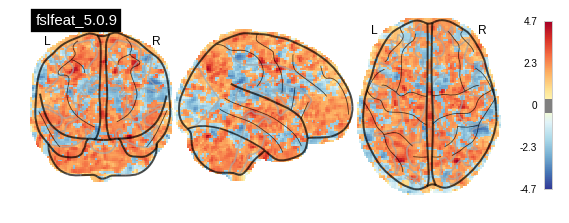

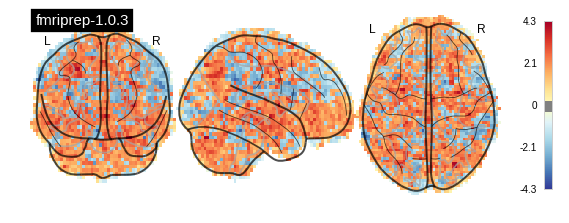

In [4]:
for idx,pipeline in enumerate(pipelines):
    plotting.plot_glass_brain(images[pipeline],title=pipeline,cmap='RdYlBu_r',
                              colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

Figure above: T-statistics images for 1 random subject.

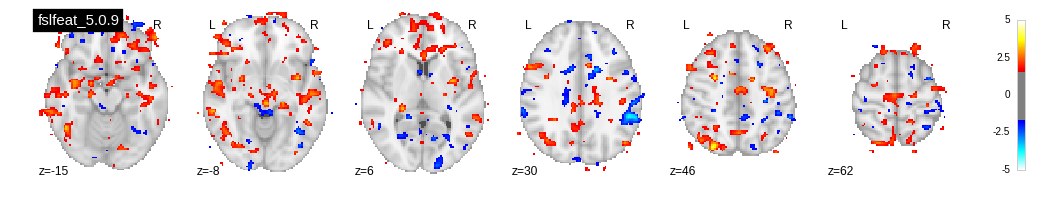

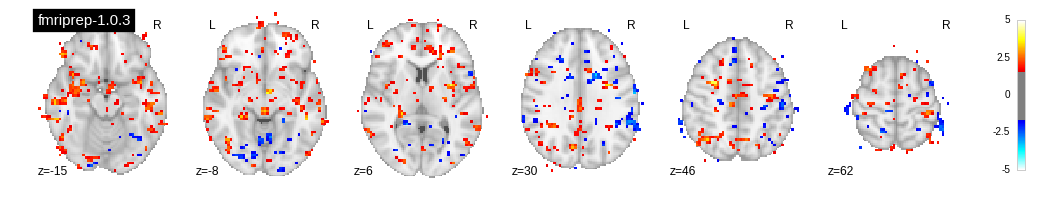

In [5]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
   plotting.plot_stat_map(images[pipeline],title=pipeline,vmax=5,display_mode='z',threshold=1.65,cut_coords=cut_coords)
plotting.show()

Figure above: T-statistics images for 1 random subject thresholded at 1.65 (two-sided p<.10)

# Compare masks

This example shows that there is much more 'activation' outside of the brain.  A comparison of the single subject masks is presented below.  The image shows the average coverage of the brain: i.e. in a voxel with value 0.5, there is signal measured in 50% of the subjects.  It can be seen that FSL uses the same mask for all subjects, while fmriprep estimates a mask for each subject.  As a result, some voxels in the brain are not present for all subjects.

In [6]:
meanmasks = {}
totalmasks = {}
subjects = {}
pipelines = ['fslfeat_5.0.9','fmriprep-1.0.3']

for pipeline in pipelines:
    taskdir = os.path.join(basedir,'fmriprep_vs_feat',pipeline,'task')
    subjects[pipeline] = os.listdir(taskdir)
    dims = [65,77,49] if pipeline.startswith('fmriprep') else [97,115,97]
    mask = np.zeros(dims+[len(subjects[pipeline])])
    for idx,subject in enumerate(subjects[pipeline]):
        cf = get_config.get_files(pipeline,subject,'stopsignal')
        maskfile = cf['standard_mask']
        #maskfile = os.path.join(taskdir,subject,'stopsignal.feat/mask.nii.gz')
        if idx==0:
            aff = nib.load(maskfile).affine
            hd = nib.load(maskfile).header
        mask[:,:,:,idx] = nib.load(maskfile).get_data()  
    mnmask = np.mean(mask,3)
    totmask = (mnmask>0)*1.
    meanmasks[pipeline] = nib.Nifti1Image(mnmask, affine = aff, header = hd)
    totalmasks[pipeline] = nib.Nifti1Image(totmask, affine = aff, header = hd)

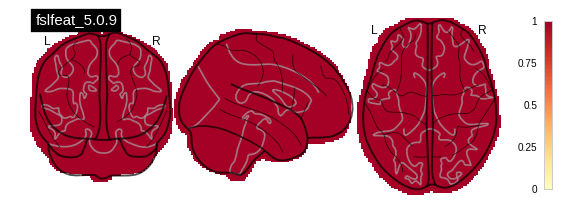

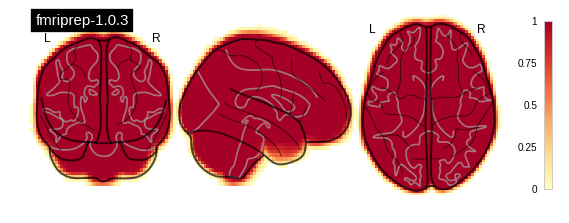

In [7]:
for idx,pipeline in enumerate(pipelines):
    plotting.plot_glass_brain(meanmasks[pipeline],title=pipeline,cmap='RdYlBu_r',
                              colorbar=True,threshold=0.01,symmetric_cbar=False)

plotting.show()

# Comparison of distribution of T-values in single subjects analyses.
We will now compare the distribution of T-values for all subjects.  To this end, we stack all T-values and plot the histogram with a kernel density estimator.

In [8]:
# collect all subjects
prepdir = os.environ.get("PREPBASEDIR")
fmriprepdir = os.path.join(prepdir,'fmriprep-1.0.3','fmriprep')
subjects = [x for x in os.listdir(fmriprepdir) if x[-4:]!='html' and x[:4]=='sub-']

subs = []
for subject in subjects:
    image = os.path.join(prepdir,'fmriprep-1.0.3','fmriprep',subject,'func',
                         '%s_task-%s_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'%(subject,'stopsignal'))
    if os.path.exists(image):
        subs.append(subject)

subs = set(subs)-set(['sub-50010','sub-10527'])
subjects = list(subs)


In [9]:
tvals = {}
for pipeline in pipelines:
    tvals[pipeline]=[]
    for subject in subjects:
        t11 = os.path.join(prepdir,'fmriprep_vs_feat/%s/task/%s/stopsignal.feat/stats/tstat11.nii.gz'%(pipeline,subject))
        im = nib.load(t11).get_data()
        imnonnul = im[im!=0]
        tvals[pipeline] += imnonnul.tolist()

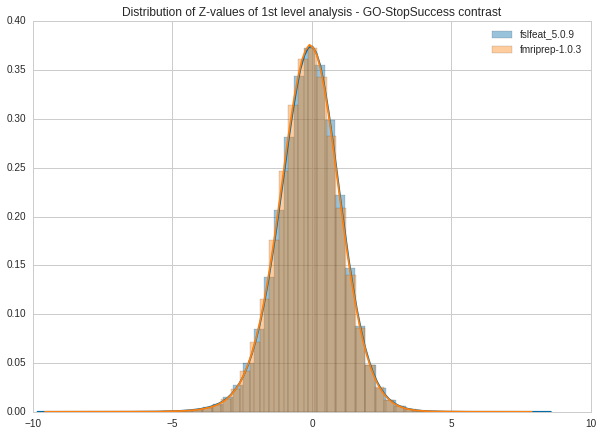

In [10]:
plt.figure(figsize=(10,7))
for pipeline in pipelines:
    sns.distplot(tvals[pipeline],label=pipeline)
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

# Smoothness estimates on the first level

Here we see how the data preprocessed using fslfeat is already much smoother (more than double) to begin with and this effect is only further propagated during the analysis.  Note that we applied a 5mm smoothing kernel after preprocessing and before modeling.

In [11]:
subjectsfile = os.path.join(basedir,'fmriprep_vs_feat/smoothness_subjects.csv')
subjects = pd.read_csv(subjectsfile)
subjects.head()

,Unnamed: 0,FWHM_data,FWHM_resid,FWHM_unpr,FWHM_zstat,pipeline,subject
0,0,1.711757,1.701597,1.025808,2.114172,fmriprep-1.0.3,sub-50073
1,1,3.483992,3.432273,1.971403,4.299600,fslfeat_5.0.9,sub-50073
2,2,1.819828,1.785026,1.072013,2.067670,fmriprep-1.0.3,sub-10329
3,3,3.578043,3.524031,1.997202,4.199431,fslfeat_5.0.9,sub-10329
4,4,1.857511,1.760015,1.085145,1.926475,fmriprep-1.0.3,sub-60038


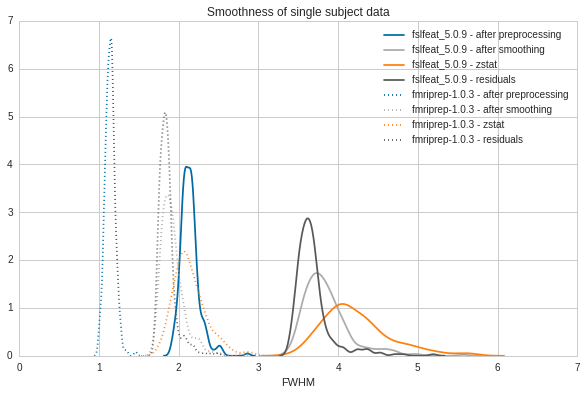

In [12]:
fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
for idy,pipeline in enumerate(pipelines):
    if idy==0:
        lsty = '-'
    else:
        lsty = ':'
    subset = subjects[subjects.pipeline==pipeline]
    sns.distplot(subset.FWHM_unpr,color=cols[0],hist=False,label="%s - after preprocessing"%pipeline,kde_kws={"linestyle": lsty})
    sns.distplot(subset.FWHM_data,color=cols[2],hist=False,label="%s - after smoothing"%pipeline,kde_kws={"linestyle": lsty})
    sns.distplot(subset.FWHM_zstat,color=cols[1],hist=False,label="%s - zstat"%pipeline,kde_kws={"linestyle": lsty})
    sns.distplot(subset.FWHM_resid,color=cols[3],hist=False,label="%s - residuals"%pipeline,kde_kws={"linestyle": lsty})

plt.title("Smoothness of single subject data")
plt.xlabel("FWHM")
plt.legend()    

# Activation count maps

Below are the activation count maps that represent the percentage of subjects with a T-value above 1.65 (p<.10) minus the percentage of subjects with a T-value below -1.65.  The various plots below show the same information in different ways.

**1. The ACM**

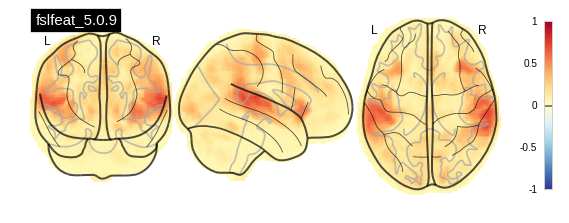

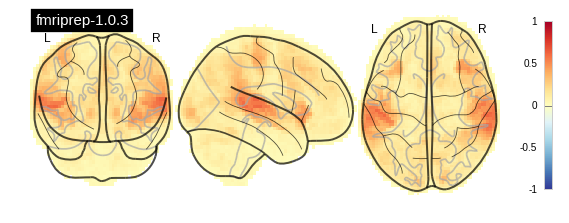

In [13]:
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_glass_brain(image,title=pipeline,vmin=-1,vmax=1,colorbar=True,cmap='RdYlBu_r',symmetric_cbar=True)
plotting.show()

**2. The ACM thresholded at 25%**: only voxels where at least 25% of the subjects have p < .10

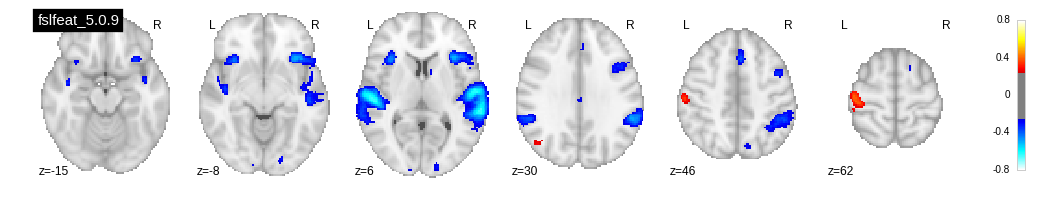

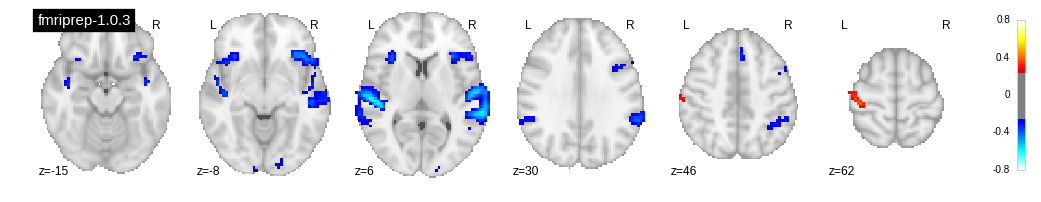

In [14]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_stat_map(image,title=pipeline,threshold=0.25,display_mode='z',cut_coords=cut_coords,vmax=0.8)
plotting.show()

**3. The distribution of the ACM:**

In contrast with the identical T-distributions, the tails of the distribution of the ACM are larger for FSL feat, indicating more intersubject overlap in the high T-values.  

This indicates higher power to detect effects at the single subject level.  This increase in power is at the cost of lower localisation power, as is indicated by the higher smoothness (both after preprocessing and after modeling).

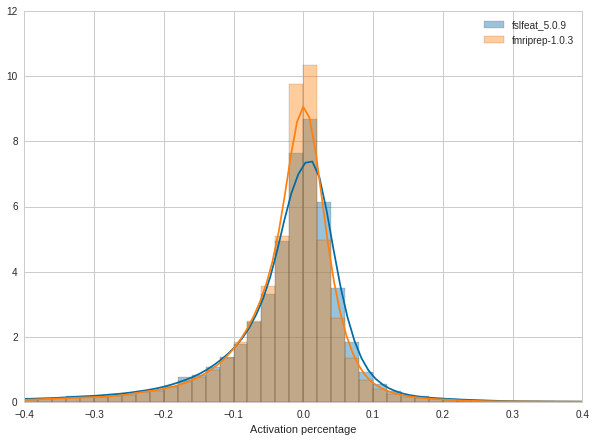

In [15]:
plt.figure(figsize=(10,7))
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    imdat = nib.load(image).get_data()
    sns.distplot(imdat[imdat != 0],label=pipeline,norm_hist=True,bins=np.arange(-1,1,0.02),kde_kws={'bw':0.015})
plt.xlim([-0.4,0.4])
plt.xlabel("Activation percentage")
plt.legend()